# K-Means Clustering

Goal: Create clusters in the data using the abstracts of each paper, using the K-means clustering algorithm.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import nltk
from nltk.stem.snowball import SnowballStemmer

import re

Convert metadata.csv to a df_abstracts, which contains the sha and abstracts of every valid paper.
- read in metadata.csv to a df
- filter out rows without a full text file
- filter out rows with multiple corresponding full text files
- create df_abstracts, which contains sha and abstracts for all valid papers


In [2]:
df = pd.read_csv("data/metadata.csv")
df_with_full = df.loc[df['has_full_text'] == True].drop(columns = 'has_full_text')

df_custom_license = df_with_full.loc[df_with_full['full_text_file'].str.match("custom_license")]
df_noncomm_use_subset = df_with_full.loc[df_with_full['full_text_file'].str.match("noncomm_use_subset")]
df_comm_use_subset = df_with_full.loc[df_with_full['full_text_file'].str.match("comm_use_subset")]
df_biorxiv_medrxiv = df_with_full.loc[df_with_full['full_text_file'].str.match("biorxiv_medrxiv")]

invalid_rows = []
for index, row in df_custom_license.iterrows():
    if ";" in row['sha']:
        invalid_rows.append(index)

df_custom_license = df_custom_license.drop(invalid_rows)

invalid_rows = []
for index, row in df_noncomm_use_subset.iterrows():
    if ";" in row['sha']:
        invalid_rows.append(index)
        
df_noncomm_use_subset = df_noncomm_use_subset.drop(invalid_rows)

invalid_rows = []
for index, row in df_comm_use_subset.iterrows():
    if ";" in row['sha']:
        invalid_rows.append(index)
        
df_comm_use_subset = df_comm_use_subset.drop(invalid_rows)

invalid_rows = []
for index, row in df_biorxiv_medrxiv.iterrows():
    if ";" in row['sha']:
        invalid_rows.append(index)
        
df_biorxiv_medrxiv = df_biorxiv_medrxiv.drop(invalid_rows)

df_all = pd.concat([df_custom_license, df_noncomm_use_subset, df_comm_use_subset, df_biorxiv_medrxiv])

df_abstracts = df_all[['sha','abstract']]

df_abstracts.to_csv("abstracts.csv")

Take sample of rows from df_abstracts to reduce runtime


In [3]:
df_abstracts_partial = df_abstracts.sample(n=10000)
df_abstracts_partial = df_abstracts_partial.dropna()

Remove rows with bad input in abstract column

In [4]:
abstract_list = df_abstracts_partial["abstract"].values
abstract_list = [x for x in abstract_list if str(x) != 'nan']
type(abstract_list)

list

Check to make sure all abstract values are strings

In [5]:
bad_inputs = 0
for i in abstract_list:
    if type(i) != str:
        bad_inputs += 1
bad_inputs

0

Use NLTK Snowball stemmer to stem all the words of the abstracts, in order to reduce variability of words with the same meaning, but different forms.

In [6]:
snowBallStemmer = SnowballStemmer("english")

abstract_list_stemmed = []

# adapted from http://jonathansoma.com/lede/algorithms-2017/classes/more-text-analysis/counting-and-stemming/
def stemming_tokenizer(str_input):
    words = re.sub(r"[^A-Za-z0-9\-]", " ", str_input).lower().split()
    words = [snowBallStemmer.stem(word) for word in words]
    return words

for i in abstract_list:
    words_list = stemming_tokenizer(i)
    words_paragraph = ""
    for j in words_list:
        words_paragraph = words_paragraph + " " + j
    abstract_list_stemmed.append(words_paragraph)

Creares a df of TFIDF vectorized abstracts

TF-IDF (term frequency-inverse document frequency) is a statistical
measure that evaluates how relevant a word is to a document in a collection.

- code adapted from https://towardsdatascience.com/natural-language-processing-feature-engineering-using-tf-idf-e8b9d00e7e76

`token_pattern=r'(?u)\b[A-Za-z]+\b'` filters out non-alphabetical characters

In [7]:
vectorizer = TfidfVectorizer(min_df = 10, max_df = 0.8, max_features = 150, stop_words = 'english', token_pattern=r'(?u)\b[A-Za-z]+\b')
vectors = vectorizer.fit_transform(abstract_list_stemmed)
feature_names = vectorizer.get_feature_names()
dense = vectors.todense()
denselist = dense.tolist()
df = pd.DataFrame(denselist, columns=feature_names)
df.head()

,abstract,acid,activ,acut,addit,age,agent,analysi,anim,antibodi,...,test,time,transmiss,treatment,type,use,vaccin,viral,virus,year
0,0.0,0.000000,0.0,0.105574,0.000000,0.0,0.0,0.099398,0.000000,0.0,...,0.000000,0.106289,0.0,0.0,0.0,0.063975,0.000000,0.082202,0.063580,0.0
1,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.113982,0.000000,0.196442,0.0
2,0.0,0.000000,0.0,0.000000,0.073486,0.0,0.0,0.068163,0.078135,0.0,...,0.070253,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.056371,0.305208,0.0
3,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.339555,0.000000,0.000000,0.000000,0.0
4,0.0,0.132339,0.0,0.000000,0.113868,0.0,0.0,0.000000,0.605361,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.067981,0.000000,0.000000,0.000000,0.0


Apply PCA to normalized TF-IDF document vectors to reduce number of dimensions to help with K-means clustering. Currently the high dimensionality decreases the effectiveness of the K-means clustering method.

Used a threshold value of 0.85 to ensure the reduced dimension vectors account for 85% of the variance.

In [8]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

pca = PCA(n_components = 0.85)
standardized_values = StandardScaler().fit_transform(df.values)
principal_components = pca.fit_transform(standardized_values)
reduced_df = pd.DataFrame(data = principal_components)
reduced_df

,0,1,2,3,4,5,6,7,8,9,...,103,104,105,106,107,108,109,110,111,112
0,0.623694,0.873472,2.425680,0.295897,-1.596278,-1.845379,-0.415677,2.237197,2.343207,-2.893156,...,1.032755,0.942533,0.310590,1.039302,-1.801571,0.258752,0.020387,0.681173,-0.210232,-0.660265
1,-3.117516,0.576479,0.085799,-0.310887,0.103581,-1.169107,2.565789,0.337846,-0.453915,0.358978,...,1.899632,-0.250510,-2.633472,0.079242,0.457568,-0.066691,-0.903539,-0.126019,-0.217979,-2.374370
2,0.854319,-1.743733,2.142173,2.628390,0.829095,-0.640695,-1.250067,1.220343,-0.660323,0.810022,...,0.543112,0.701682,-0.898964,0.809838,0.145409,1.364180,-0.168689,0.484947,-2.044967,-1.215760
3,1.609079,1.705152,-2.379748,2.902200,-0.964476,-0.402134,1.600693,-0.127923,1.900481,-0.747956,...,0.133250,1.553524,-0.445188,-1.036809,-1.679192,0.683492,-0.230994,0.241778,-0.701655,-0.867356
4,-0.371034,-0.330841,-0.294178,0.303878,0.643269,0.264489,-0.789924,0.200249,0.510880,-1.900939,...,0.728741,-0.220124,-0.553202,1.125929,-0.304210,1.056203,0.255733,0.356913,0.506103,0.227623
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8696,-1.949922,-1.253308,-1.897284,-1.906998,-1.938636,0.403117,0.309176,0.646809,-2.325649,0.233817,...,-1.089941,0.470208,-0.709908,-0.107220,-0.444930,-1.781311,-0.886685,-0.616010,-0.096681,1.436692
8697,-3.121738,-0.463495,0.447208,0.171093,-0.470804,-0.659357,2.757976,0.754654,-2.927550,0.084128,...,-0.427267,0.806299,0.580537,1.602837,-0.328030,0.266600,-0.676617,-1.663658,-1.400108,-0.058953
8698,-2.218274,1.364770,0.388344,-0.891971,1.595338,0.172147,1.621054,3.352182,-2.953565,1.733597,...,-0.944386,0.258950,-1.137978,-0.298451,0.259288,0.859345,0.366560,-1.192837,0.948725,-0.151289
8699,-3.412329,2.302082,-0.903665,-0.363598,1.618678,-3.595763,1.000312,-2.357828,2.031093,0.590531,...,-3.412317,-0.013261,-1.030234,-1.026725,0.548068,0.511980,-0.502248,-0.924417,-1.327458,0.576709


Create an elbow plot to identify the ideal number of clusters based on sum of squared errors
- plot code adapted from https://www.kaggle.com/jbencina/clustering-documents-with-tfidf-and-kmeans

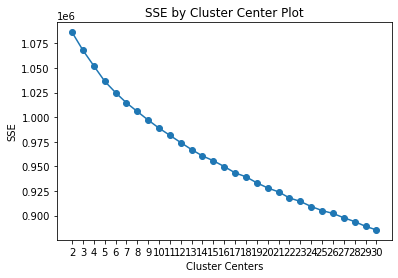

In [9]:
def find_optimal_clusters(data, max_k):
    iters = range(2, max_k+1)
    
    sse = []
    for k in iters:
        sse.append(KMeans(n_clusters=k, n_init=20).fit(data).inertia_)
        
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')
    
find_optimal_clusters(reduced_df, 30)

The below cell displays an example of the TF-IDF vector for a single paper.

In [10]:
row_dict = df.loc[ 0 , : ].to_dict()

from collections import OrderedDict

dd = OrderedDict(sorted(row_dict.items(), key=lambda x: x[1], reverse=True))
dd

OrderedDict([('demonstr', 0.3157473177250234),
             ('coronavirus', 0.30539968463561634),
             ('data', 0.2924712021492633),
             ('speci', 0.2584824658284724),
             ('novel', 0.2258578492458141),
             ('syndrom', 0.22337559754338274),
             ('gene', 0.21569518287496733),
             ('emerg', 0.2133027969700257),
             ('relat', 0.20910838054086756),
             ('compar', 0.200519309104949),
             ('studi', 0.19493229196300754),
             ('dure', 0.19458820866391488),
             ('respiratori', 0.17657120151920586),
             ('sars', 0.1445810302105377),
             ('sar', 0.13833248997191983),
             ('replic', 0.11913554624096447),
             ('rate', 0.11812777639997363),
             ('outbreak', 0.11622745434338931),
             ('determin', 0.11039386866175674),
             ('factor', 0.10778974279698342),
             ('recent', 0.10773198461569206),
             ('time', 0.10628886439882891),

Add assigned cluster column to `df_partial_abstracts`

In [11]:
clusters = KMeans(n_clusters=14).fit_predict(df)

df_abstracts_partial["cluster"] = clusters
df_abstracts_partial.sort_values("cluster")

,sha,abstract,cluster
22053,108b012df7e6ae774a2a83243c0662f376637426,Porcine epidemic diarrhea virus emerged in Nor...,0
6824,42085d63b0fbfc03c555626cadd11d55774c5c64,Abstract Angiotensin-converting enzyme (ACE) p...,0
21417,710dd69c07a692bbdcd7261bb4508cd9935556c6,The positive-strand coronavirus genome of ~30 ...,0
9524,00f12a2adcfe8f8f62edfcad80b541c44692f2fa,Abstract RNA molecules are functionally divers...,0
20114,a3778f543ef74ff3a0dd90250221b77ee38d7533,BACKGROUND: RNA exhibits a variety of structur...,0
...,...,...,...
15613,65dbbb1f17b63eb6e36782d0523ed0e501ea5b1f,Carbohydrates and their conjugates are involve...,13
11180,91531177c812eedf1e965f086c510c6e603250ce,Abstract Thirty years after passage of legisla...,13
22306,9bad9c5864165815b35dd2c78cd0ed7b285f0517,This paper analyzes the main trend of the deve...,13
11934,8c933d955d8adf7828db8ff08bd7106ea6fa448a,Abstract Porcine reproductive and respiratory ...,13


In [12]:
clustercounts = df_abstracts_partial[["abstract", "cluster"]]
clustercounts = clustercounts.groupby("cluster", as_index=False).count().sort_values("cluster", ascending=True)
clustercounts

,cluster,abstract
0,0,317
1,1,878
2,2,504
3,3,546
4,4,612
5,5,327
6,6,587
7,7,590
8,8,870
9,9,1787


Histogram of number of papers in each cluster to observe rough results of the model:

([<matplotlib.axis.XTick at 0x7fecd9c86850>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

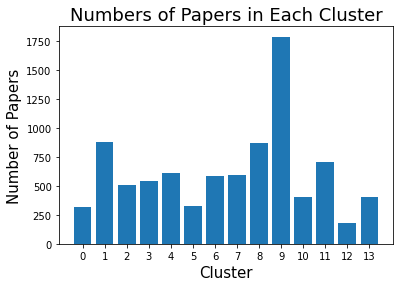

In [13]:
plt.bar('cluster', 'abstract', data=clustercounts)
plt.xlabel("Cluster", size=15)
plt.ylabel("Number of Papers", size=15)
plt.title("Numbers of Papers in Each Cluster", size=18)
plt.xticks(clustercounts["cluster"].values)

Use t-SNE to reduce the >100 dimensional points to two dimensions in order to visualize the clustering results.

In [14]:
from sklearn.manifold import TSNE

tsne_results = TSNE(n_components=2).fit_transform(reduced_df)

<AxesSubplot:xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

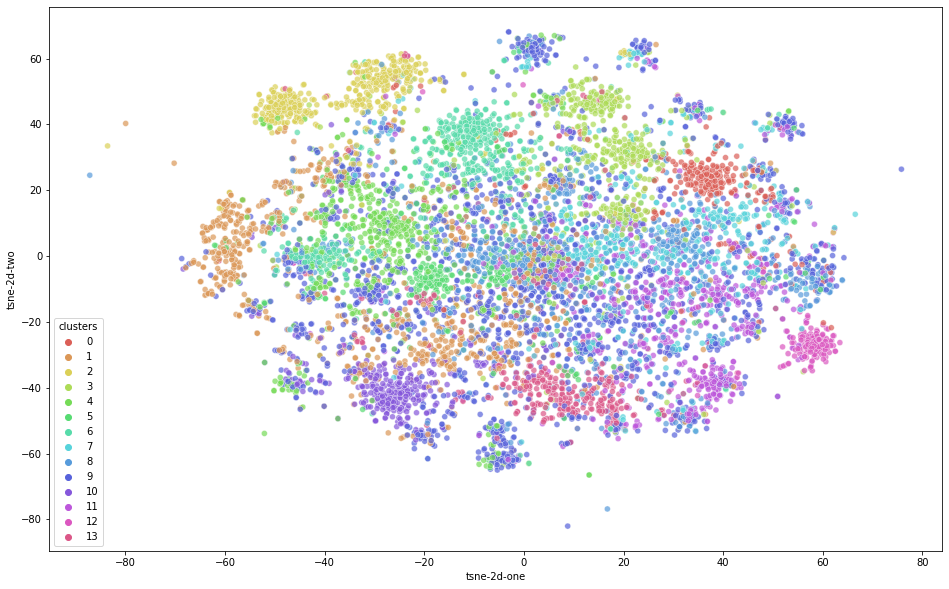

In [15]:
# adapted from https://towardsdatascience.com/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b

df_tsne = pd.DataFrame()

df_tsne['tsne-2d-one'] = tsne_results[:,0]
df_tsne['tsne-2d-two'] = tsne_results[:,1]
df_tsne["clusters"] = clusters

plt.figure(figsize=(16,10))
sns.scatterplot(
    x='tsne-2d-one',
    y='tsne-2d-two',
    data=df_tsne,
    palette=sns.color_palette("hls", 14),
    legend="full",
    alpha=0.7,
    hue="clusters"
)

In [16]:
# The sample of papers with their assigned clusters
df_abstracts_partial

,sha,abstract,cluster
27327,11217ee4e2bcf58f21011db8ff3d166aad2691ca,The phylogenetic and taxonomic relationships a...,9
39728,84c3cb4cff4551bf95b6f79bd6c52525faee0a44,The African swine fever virus (ASFV) has sever...,7
24563,64fbda4f1a32fd2610ce90ef77b775ec4676bec8,Bats and rodents are being increasingly recogn...,6
18221,57df78198df2774be87635b81f850b6eeb2dd6f8,Objectives To identify and summarise existing ...,10
27370,3062fc222bccc8c520612d9d6c9b91f048be12b8,Human embryonic stem cells (hESCs) have been r...,11
...,...,...,...
24907,804533d11a3f44908f514922d18f2a79826471c2,The peroxisome proliferator-activated receptor...,11
14089,51f9f787ef1fe06c169838b518a134458cd07893,Abstract HCMV infection represents a life-thre...,9
9175,a857ddce8f702e40d71bd2e6e8d04611b4850bed,Abstract Ebola (EBOV) and Zika viruses (ZIKV) ...,8
22737,608a7194b225bedf27e124dfbe8f2acecbca587f,Exosomes are extracellular vesicles released u...,8
